# Image Filtering

The main objectives of this module are:

* Implement point filtering with look-up tables.
* Implement region filtering with kernel convolution, morphological operations and edge detection.
* Understand spatial frequency information with the Fourier transform.

## 1. Look-up tables

Look-up tables are a very useful tool to perform simple pixel-level filtering of an image.

Numpy arrays indexing ([see reference here](http://docs.scipy.org/doc/numpy/user/basics.indexing.html)) is a very powerful tool, but can be a bit counter-intuitive at first. We will use it to quickly create and use look-up tables to transform an image.

Look at the short example below. 

We construct an image with 4 possible values for each pixel (-> $I(x,y) \in \{0,1,2,3\}$). We then build the following LUT:

|Input value|Output value|
|--|--|
|0|2|
|1|3|
|2|1|
|3|0|

And we apply it on the image.

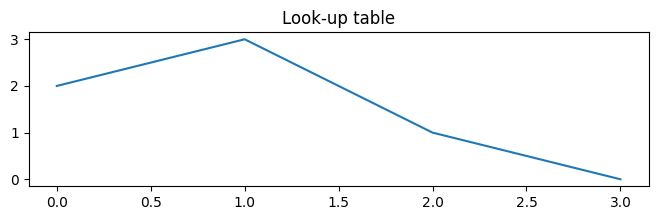

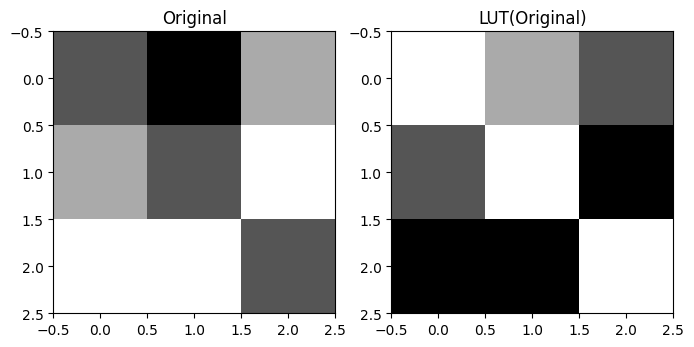

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Let's create a 3x3 "image" with 4 possible pixel values (in [0,3])
im = np.array([[1,0,2],[2,1,3],[3,3,1]])

# look-up table is a vector of size 4 mapping the new value for the pixels of m
lut = np.array([2,3,1,0]) # maps 0 -> 2, 1 -> 3, 2 -> 1, 3 -> 0

plt.figure(figsize=(8,2))
plt.plot(lut)
plt.title('Look-up table')
plt.show()

# we can use numpy vector indexing to apply the look-up table:
new_im = lut[im] # This will create a new array with the same size as m

plt.figure(figsize=(8,4))
plt.subplot(1,2,1) #supblot is useful to display images side-by-side
plt.imshow(im, cmap=cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(new_im, cmap=cm.gray)
plt.title('LUT(Original)')
plt.show()

**Starting from this example, create the following LUTs** and apply them to the "walking.jpg" image:
1. For inverting an image (so that $0 \rightarrow 255$, $255 \rightarrow 0$)
1. To keep only graylevel such that $g \ge t$, setting all other values to 0.
1. To reduce the number of gray levels from 256 to 8 (so that $255 \rightarrow 7$, $0 \rightarrow 0$).
1. To "stretch" the histogram so that, given a **minimum value** $T_{min}$ and a **maximum value** $T_{max}$, we have :
    * If $I(x,y) < T_{min}$, the new value is set to 0
    * If $I(x,y) > T_{max}$, the new value is set to 255
    * Values between $T_{min}$ and $T_{max}$ are stretched to cover the entire histogram.
1. to perform an **equalization** of the cameraman image (so that the histogram becomes "as flat as possible")

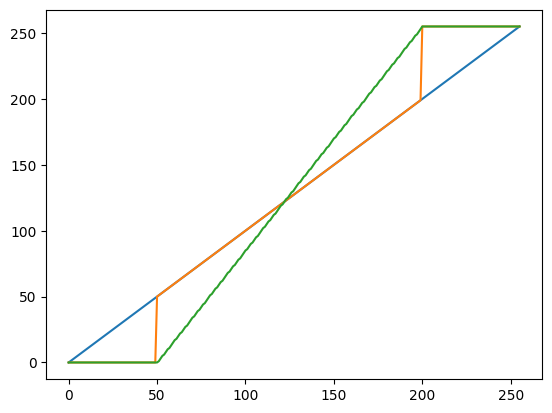

In [2]:
from skimage.io import imread,imshow,imsave

im = imread('walking.jpg')

# 1. Inverting an image
lut_invert = np.array([255 - i for i in range(256)])

# 2. Threshold on grey level
threshold = 150
lut_threshold = np.array([i if i > threshold else 0 for i in range(256)])

# 3. Reduce the number of gray levels
gray_levels = 10 # 1 = binary image, 256 = basic image
lut_reduce = np.array([round(i/round(256/gray_levels))*round(256/gray_levels)  for i in range(256)])

# We can also use integer division
lut_reduce2 = np.array([i//32 for i in range(256)])

# 4. Stretch the histogram of an image (Auto-Level)
# Compress histogram
th_min, th_max = 30, 200
lut_compress = np.array([round((i * (th_max - th_min) /256) + th_min) for i in range(256)])

# Stretch histogram

# Cumulative histogram of the image
def cumulative(im):
    cumul_hist = np.zeros(256)
    c = 0
    for v in range(256):
        c += (im==v).sum()
        cumul_hist[v] = c
    cumul_hist /= cumul_hist.max()
    return cumul_hist

# Find boundaries from percentile of pixel
def find_boundaries(im, percentile):
    h = cumulative(im)
    for v in range(256):
        if h[v] > percentile/100:
            break
    min_bound = v - 1

    for v in range(256):
        if h[v] < (100 - percentile)/100:
            break
    max_bound = (255 - v) + 1

    return min_bound, max_bound

# All values bellow minimum threshold are set to 0, all values above maximum threshold are set to 255
# Then between the two threshold, we apply a linear mapping
th_min, th_max = 50, 200
lut_stretch = np.arange(256)
plt.plot(lut_stretch)

# low_val, high_val = find_boundaries(im, 30)
low_val, high_val = 0, 255
lut_stretch[:th_min], lut_stretch[th_max:] = low_val, high_val
plt.plot(lut_stretch)

# linear_mapping = (high_val-low_val)/(th_max-th_min) * (np.arange(256) - th_min) + low_val
# lut_stretch[th_min:th_max] = linear_mapping[th_min:th_max]

lut_stretch[th_min:th_max] = (high_val-low_val)/(th_max-th_min) * (lut_stretch[th_min:th_max] - th_min) + low_val
plt.plot(lut_stretch)

# 5. Equalization of an image

# Values that are in large number are stretched on more values,
# while values with less occurrence are compressed on less values
# Allows increasing drastically the contrast

# Translates in a look-up table as a big slope for peeks and low slope for flats
# So that is maps peeks on more values and maps flats on fewer values

# This is well represented by the cumulative histogram -> becomes our look-up table

histogram = cumulative(im)
lut_equalization = (histogram*255).astype('uint8')

# plt.figure()
# plt.plot(lut_equalization)
# plt.show()

def show():
    nb_line = 8
    plt.figure(figsize=(15,15))
    plt.gray()

    plt.subplot(nb_line,2,1)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.subplot(nb_line,2,2)
    plt.hist(im.flatten(), bins=np.arange(257))

    plt.subplot(nb_line,2,3)
    plt.imshow(lut_invert[im], cmap=plt.cm.gray)
    plt.subplot(nb_line,2,4)
    plt.hist(lut_invert[im].flatten(), bins=np.arange(257))

    plt.subplot(nb_line,2,5)
    plt.imshow(lut_threshold[im], cmap=plt.cm.gray)
    plt.subplot(nb_line,2,6)
    plt.hist(lut_threshold[im].flatten(), bins=np.arange(257))

    plt.subplot(nb_line,2,7)
    plt.imshow(lut_reduce[im], cmap=plt.cm.gray)
    plt.subplot(nb_line,2,8)
    plt.hist(lut_reduce[im].flatten(), bins=np.arange(257))

    plt.subplot(nb_line,2,9)
    plt.imshow(lut_compress[im], cmap=plt.cm.gray)
    plt.subplot(nb_line,2,10)
    plt.hist(lut_compress[im].flatten(), bins=np.arange(257))

    plt.subplot(nb_line,2,11)
    plt.imshow(lut_stretch[im], cmap=plt.cm.gray)
    plt.subplot(nb_line,2,12)
    plt.hist(lut_stretch[im].flatten(), bins=np.arange(257))

    plt.subplot(nb_line,2,13)
    plt.imshow(lut_equalization[im], cmap=plt.cm.gray)
    plt.subplot(nb_line,2,14)
    plt.hist(lut_equalization[im].flatten(), bins=np.arange(257))
    plt.show()

# show()

**Need more help? You can check the following videos:**

* [Look-Up Tables](https://www.youtube.com/watch?v=PHiiKoSsVac&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=13)
* [Auto-levels](https://www.youtube.com/watch?v=DLN4jfBJakQ&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=14)
* [Equalization](https://www.youtube.com/watch?v=C44WuMUudik&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=15)

## 2. Kernel convolution

Kernal convolution allows us to filter an image based on the values of a neighborhood.

Write a program that applies a 3x3 kernel convolution on an image. Use it on the "walking" image to perform a mean filter.

In [3]:
from scipy.signal import convolve2d

im = imread('walking.jpg')

# define the kernel
kernel_size = 3

# Prewitt
prewitt_ver = np.array([[1, 0, -1],[1, 0, -1],[1, 0, -1]]).astype(float)
prewitt_hor = prewitt_ver.T  # We can use .T at the end of np.array definition to invert rows and columns of the matrix

# Sobel
sobel_ver = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]]).astype(float)
sobel_hor = sobel_ver.T

# Robert
robert_1 = np.array([[1,0],[0,-1]]).astype(float)
robert_2 = np.array([[0,1],[-1,0]]).astype(float)

# output of filter :
def conv(im, kernel):
    im_out = np.zeros(im.shape)
    for y in range(kernel_size//2, im.shape[0] - kernel_size//2):
        for x in range(kernel_size//2, im.shape[1] - kernel_size//2):
            region = im[y - kernel_size//2:y + kernel_size//2 + 1, x - kernel_size//2:x + kernel_size//2 + 1]
            for i in range(kernel_size):
                for j in range(kernel_size):
                    im_out[y,x] += region[i,j] * kernel[i,j]

    return im_out

# Due to size of the kernel, it won't work on the edges because of the undefined pixels
# To solve it, we loop on each axis from after the edge to before the edge

# Note : this method is not to be used in general, to many loops, takes too long to compute
# Since here we are doing an element-wise operation, we can do it directly on the full array

def conv_indexing(im, kernel):
    im_out = np.zeros(im.shape)
    for y in range(kernel_size//2, im.shape[0] - kernel_size//2):
        for x in range(kernel_size//2, im.shape[1] - kernel_size//2):
            im_out[y,x] = (im[y-kernel_size//2:y+kernel_size//2+1, x-kernel_size//2:x+kernel_size//2 + 1]*kernel).sum()

    return im_out

# can be done even faster using scipy convolve2d
convolution = convolve2d(im, prewitt_ver, mode='same')
# From kernel definition, we can see that vertical (horizontal if kernel_inv) edges of object in the image are emphasized

def show_convolution():
    plt.figure(figsize=[15,8])
    plt.subplot(1,3,1)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.subplot(1,3,2)
    plt.imshow(convolution, cmap=plt.cm.gray)
    plt.subplot(1,3,3)
    plt.imshow(np.abs(convolution), cmap=plt.cm.gray)
    plt.show()
    plt.show()

# show_convolution()

def show():
    pre_v = convolve2d(im, prewitt_ver)
    pre_h = convolve2d(im, prewitt_hor)
    sob_v = convolve2d(im, sobel_ver)
    sob_h = convolve2d(im, sobel_hor)
    rob_1 = convolve2d(im, robert_1)
    rob_2 = convolve2d(im, robert_2)

    plt.figure(figsize=[15,15])
    plt.subplot(3,2,1)
    plt.imshow(pre_v, cmap=plt.cm.gray)
    plt.subplot(3,2,2)
    plt.imshow(sob_v, cmap=plt.cm.gray)
    plt.subplot(3,2,3)
    plt.imshow(pre_h, cmap=plt.cm.gray)
    plt.subplot(3,2,4)
    plt.imshow(sob_h, cmap=plt.cm.gray)
    plt.subplot(3,2,5)
    plt.imshow(rob_1, cmap=plt.cm.gray)
    plt.subplot(3,2,6)
    plt.imshow(rob_2, cmap=plt.cm.gray)
    plt.show()

# show()


Using the [median filter](https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#skimage.filters.rank.median) and the [mean filter](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.mean) from scikit-image, compare the behaviour of the two filters with neighborhood of increasing sizes on the "noisy" astronaut image:

In [4]:
from skimage.io import imread, imshow
from skimage.filters.rank import mean, median
from skimage.filters import gaussian
from skimage.morphology import rectangle, disk

im = imread('astronaut_noisy.jpg')

# Mean filter (Kernel is all ones : causes blurr, proportional to kernel size)
kernel = np.ones((3, 3))
# Normalize to make it compute automatically the mean value
kernel /= kernel.sum()

# im_mean = convolve2d(im, kernel)
im_mean = mean(im, rectangle(3, 3))

# Gaussian filter
im_gaussian = gaussian(im, 2)

# Median filter
def median_filter(im, size):
    # size is the kernel size
    im_out = np.zeros(im.shape)
    for y in range(size//2, im.shape[0]-size//2):
        for x in range(size//2, im.shape[1]-size//2):
            im_out[y,x] = np.median(im[y-size//2:y+size//2+1, x-size//2:x+size//2 + 1])

    return im_out

# im_median = median_filter(im, 3)
im_median = median(im, disk(2))

# Compared to previous ones, when applying median filter, borders remains sharp where mean filter
# creates a gradient of color when there is an edge

# Median filter preserve the borders !!!!
# It is also a better way to average the values when denoising

def show():
    plt.figure(figsize=[15,8])
    plt.gray()
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.subplot(1,3,2)
    plt.imshow(mean(im, disk(2)))
    plt.subplot(1,3,3)
    plt.imshow(median(im, disk(2)))
    plt.show()


    for i in range(0,20,4):
        plt.figure(figsize=[15,8])
        plt.gray()
        plt.subplot(1,3,1)
        plt.imshow(im)
        plt.subplot(1,3,2)
        plt.imshow(mean(im, disk(i)))
        plt.subplot(1,3,3)
        plt.imshow(median(im, disk(i)))
        plt.show()

# show()

**Need more help? You can check the following videos:**

* [Kernel convolution](https://www.youtube.com/watch?v=FaTvGWPnLng&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=16)
* [Mean and Median filters](https://www.youtube.com/watch?v=GLTuF3lwDLs&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=17)

## 3. 2D Fourier transform

The 2D Fourier transform allows us to get a representation of the spatial frequencies present in an image. A very powerful way of filtering images is to modify those frequencies directly by modifying the "Fourier image", and to use the inverse transform to get the pixel values of the filtered image.

Let's illustrate that with a fake example. We start with a completely random signal and compute the Fourier transform. Note that the Fourier image is complex, so we use its amplitude. As the range of amplitudes is so high that we don't see much in the resulting image, we display the log of the amplitude.

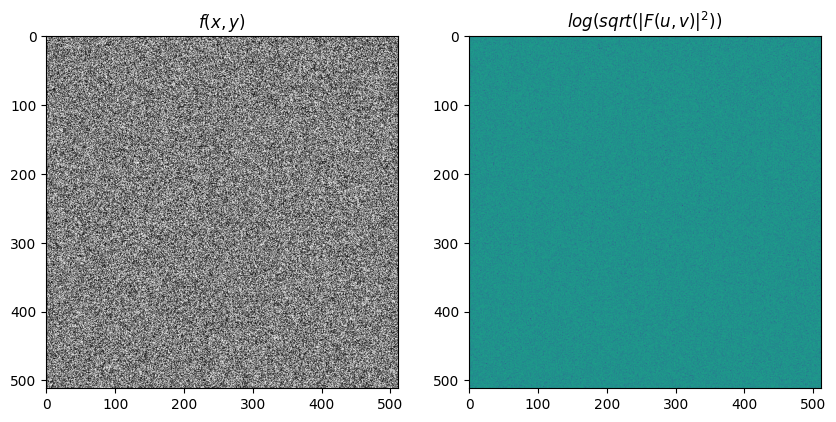

In [5]:
from numpy.fft import fft2,ifft2,fftshift,ifftshift
# fft2 -> Fourier transform
# ifft2 -> Inverse transform
# fftshift & ifftshift -> reorganize the "Fourier image" to make it more easily interpretable.

im = np.random.random((512,512))
f = fftshift(fft2(im))
amplitude = np.sqrt(np.real(f)**2+np.imag(f)**2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude))# show log so as to see more than just the global maximum
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

We could now, for instance, decide to add an horizontal frequency by creating peaks in the Fourier image on the horizontal axis. The further away from the center we put the peaks, the higher the frequency.

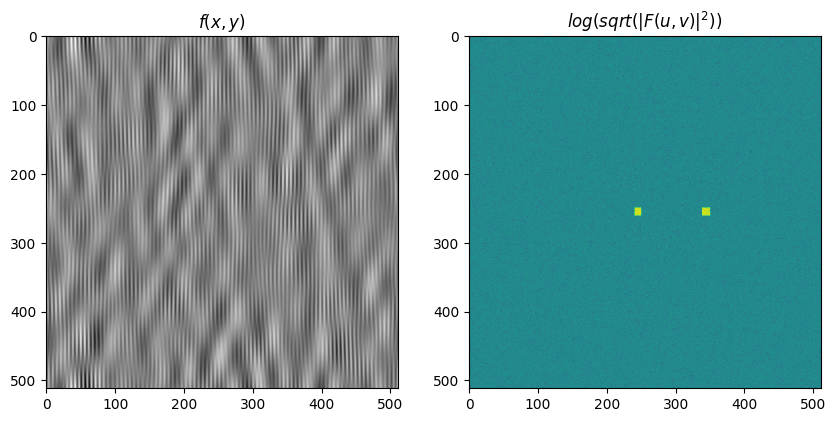

In [6]:
f2 = f.copy()
f2[250:262,338:350] *= 1000
f2[250:262,240:250] *= 1000
amplitude = np.sqrt(np.real(f2)**2+np.imag(f2)**2)
im2 = ifft2(ifftshift(f2)).real

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im2,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude), cmap='viridis')# show log so as to see more than just the global maximum
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

Now we could also decide to mask the central region, which would remove the peaks that we just created and put all those values at zero. The image will once again look random:

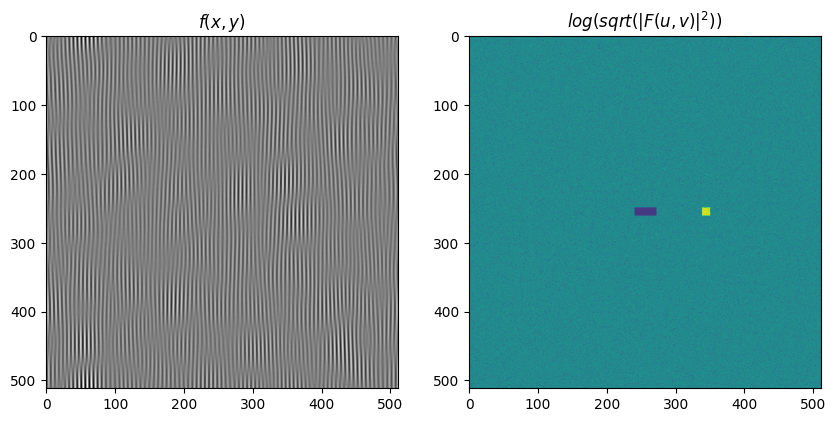

In [7]:
f3 = f2.copy()
f3[250:262,240:272] = 0
amplitude = np.sqrt(np.real(f3)**2+np.imag(f3)**2)
im3 = ifft2(ifftshift(f3)).real

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im3,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude, where=amplitude>0))
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

Starting from those examples and the code below:

1. Use the Fourier transform to reduce the [dithering](https://en.wikipedia.org/wiki/Dither) of the *moire.png* image by building a low-pass filter.
1. Build a high-pass filter using Fourier transform and apply the filter to the "walking" image.

/var/folders/4s/d117mc114zx7dd3fd3wr9xb00000gn/T/ipykernel_3560/3462580632.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = imread('moire1.png').astype(np.float)


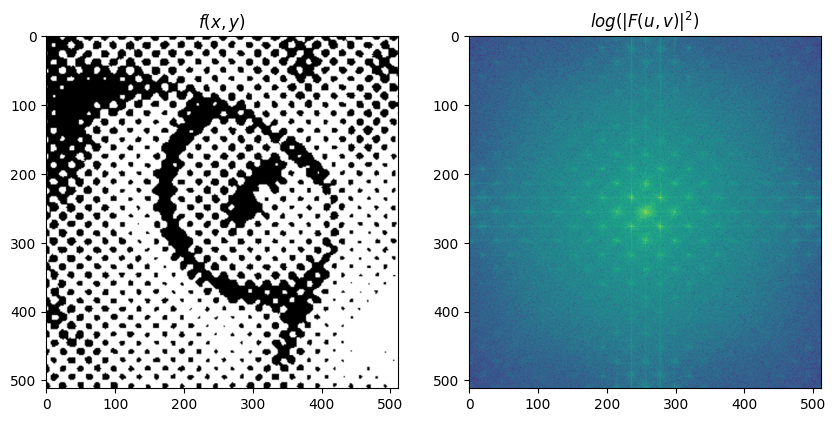

In [8]:
im = imread('moire1.png').astype(np.float)
f = fftshift(fft2(im)) # shift Fourier image so that the center corresponds to low frequencies

amplitude = np.sqrt(np.real(f)**2+np.imag(f)**2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude))# show log so as to see more than just the global maximum
plt.title('$log(|F(u,v)|^2)$')
plt.show()

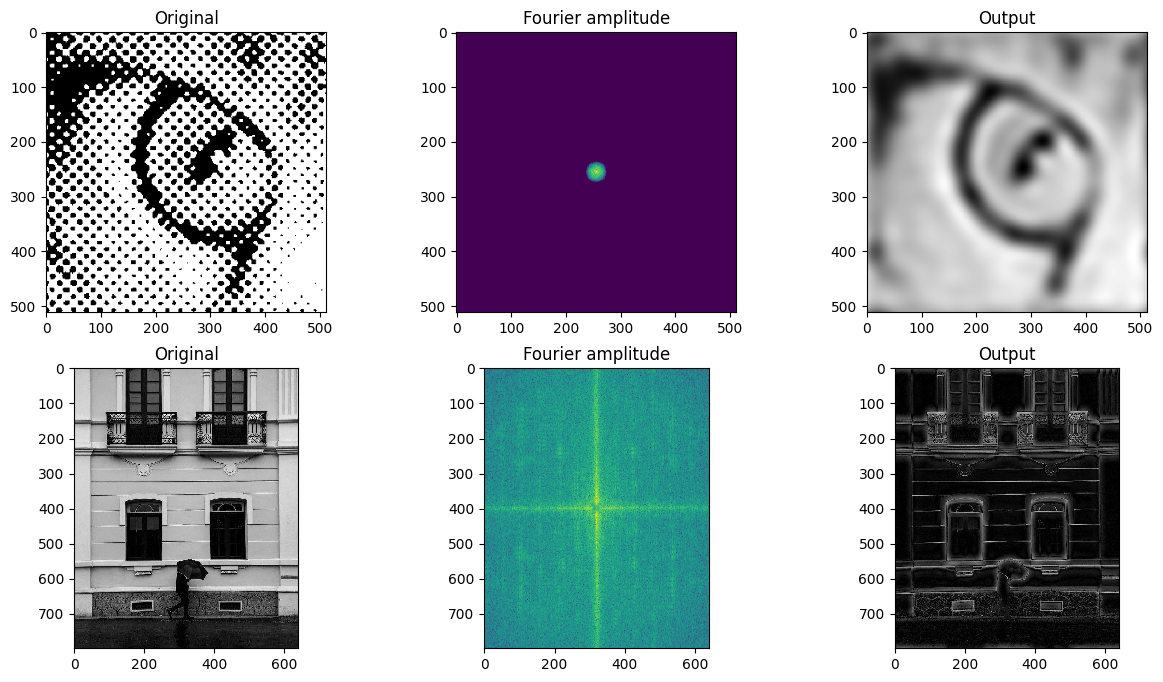

In [9]:
from skimage.morphology import disk
from skimage.filters import gaussian

def ampl(f):
    return np.sqrt(np.real(f)**2 + np.imag(f)**2)

im = imread('moire1.png').astype(float)
f = fftshift(fft2(im))

# 1. Reduce dithering
# Fourier mask
# Rectangular Mask
# mask = np.zeros(im.shape)
# mask[mask.shape[0]//2-disk_size:mask.shape[0]//2+disk_size, mask.shape[1]//2-disk_size:mask.shape[1]//2+disk_size] = 1
# Disk Mask
disk_size = 11
mask = np.zeros(im.shape)
mask[mask.shape[0]//2-disk_size:mask.shape[0]//2+disk_size+1, mask.shape[1]//2-disk_size:mask.shape[1]//2+disk_size+1] = disk(disk_size)
mask = gaussian(mask, 2)  # Smoothen the borders of the mask by applying Gaussian filter

f2 = f*mask

result = ifft2(ifftshift(f2)).real


# 2. High-pass filter using Fourier transform
im2 = imread('walking.jpg').astype(float)
f3 = fftshift(fft2(im2))

disk_size = 15
mask = np.ones(im2.shape)
mask[mask.shape[0]//2-disk_size:mask.shape[0]//2+disk_size+1, mask.shape[1]//2-disk_size:mask.shape[1]//2+disk_size+1] = 1 - disk(disk_size)
mask = gaussian(mask, 5)

f4 = f3*mask

# High-pass filter, will keep high frequencies, which are the borders in the image
result2 = ifft2(ifftshift(f4)).real

def show():
    plt.figure(figsize=[15,8])
    plt.subplot(2,3,1)
    plt.imshow(im, interpolation='none', cmap = plt.cm.gray)
    plt.title('Original')
    plt.subplot(2,3,2)
    plt.imshow(np.log(ampl(f2) + 1), interpolation='none', cmap='viridis')
    plt.title('Fourier amplitude')
    plt.subplot(2,3,3)
    plt.imshow(result, interpolation='none', cmap=plt.cm.gray)
    plt.title('Output')

    plt.subplot(2,3,4)
    plt.imshow(im2, interpolation='none', cmap = plt.cm.gray)
    plt.title('Original')
    plt.subplot(2,3,5)
    plt.imshow(np.log(ampl(f4) + 1), interpolation='none', cmap='viridis')
    plt.title('Fourier amplitude')
    plt.subplot(2,3,6)
    plt.imshow(np.abs(result2), interpolation='none', cmap=plt.cm.gray)
    plt.title('Output')
    plt.show()

show()

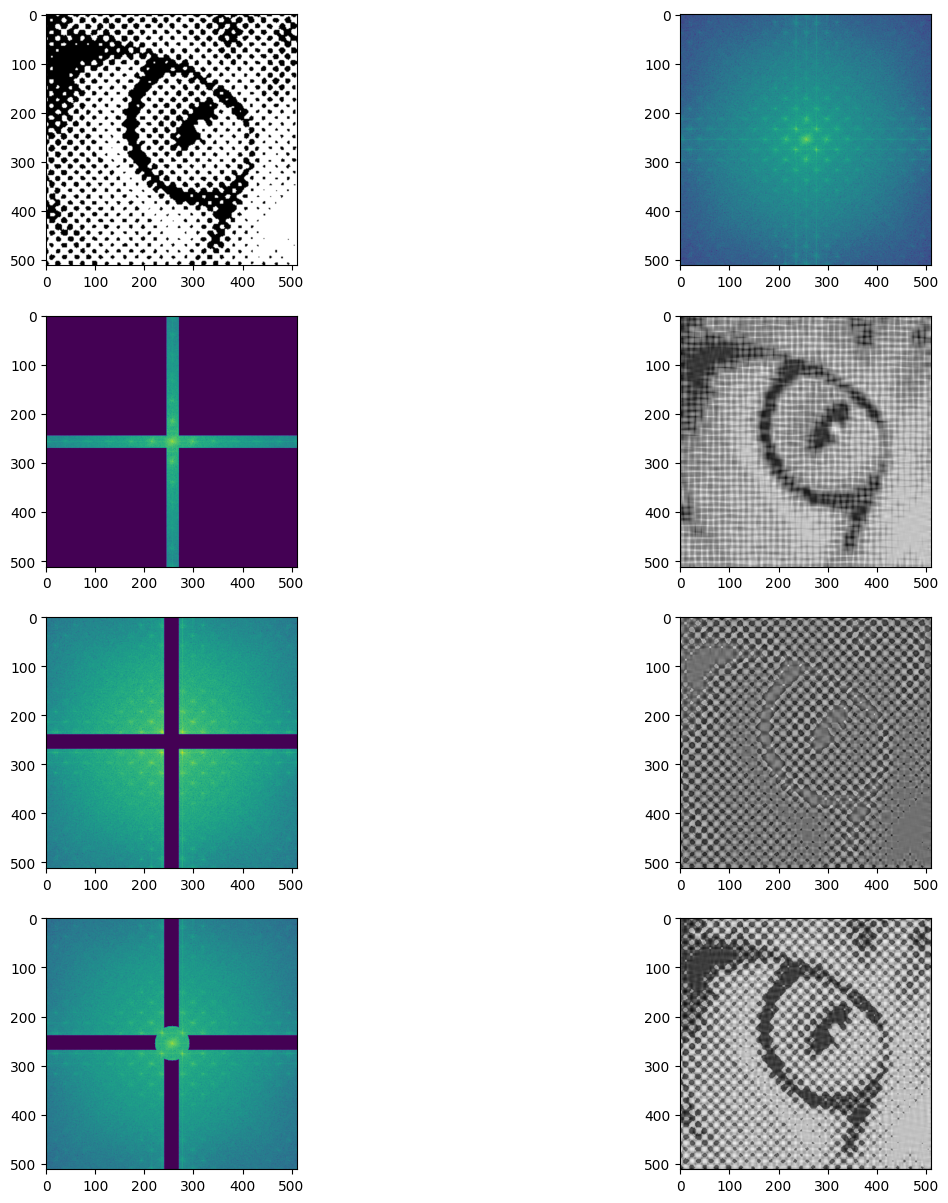

In [10]:
im = imread('moire1.png').astype(float)
f = fftshift(fft2(im))

mask1 = np.zeros(im.shape)
mask1[245:270,:] = 1
mask1[:,245:270] = 1

f1 = f*mask1

mask2 = np.zeros(im.shape)

mask2[:240,:240] = 1
mask2[270:,:240] = 1
mask2[270:,270:] = 1
mask2[:240,270:] = 1

f2 = f*mask2

disk_size = 35
mask3 = np.zeros(im.shape)
mask3[mask3.shape[0]//2-disk_size:mask3.shape[0]//2+disk_size+1, mask3.shape[1]//2-disk_size:mask3.shape[1]//2+disk_size+1] = (1 - disk(disk_size))==0
mask3[mask2 == 1] = 1

f3 = f*mask3

result1 = ifft2(ifftshift(f1)).real
result2 = ifft2(ifftshift(f2)).real
result3 = ifft2(ifftshift(f3)).real

def show():
    plt.figure(figsize=[15,15])
    plt.subplot(4,2,1)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.subplot(4,2,2)
    plt.imshow(np.log(ampl(f) + 1))
    plt.subplot(4,2,3)
    plt.imshow(np.log(ampl(f1) + 1))
    plt.subplot(4,2,4)
    plt.imshow(result1, cmap=plt.cm.gray)
    plt.subplot(4,2,5)
    plt.imshow(np.log(ampl(f2) + 1))
    plt.subplot(4,2,6)
    plt.imshow(result2, cmap=plt.cm.gray)
    plt.subplot(4,2,7)
    plt.imshow(np.log(ampl(f3) + 1))
    plt.subplot(4,2,8)
    plt.imshow(result3, cmap=plt.cm.gray)
    plt.show()

show()

**Need more help? You can check the following videos:**

* [Understanding the 2D Fourier transform](https://www.youtube.com/watch?v=bsNQpeBZ7IY&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=18)
* [Filters in Fourier space](https://www.youtube.com/watch?v=8g-sE7wkKpU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=19)

## 4. Morphological operations

* For morphology functions, [see the skimage documentation](http://scikit-image.org/docs/dev/api/skimage.morphology.html?highlight=morphology#module-skimage.morphology)

Starting from the example below:

1. Using the "opening" operation with a disk structuring element of increasing size, determine how many circles of any given radius there are in the *circles.png* image.
1. Build a morphological filter that eliminates one size of circles.

Number of big circles : 4
Number of medium circles : 6
Number of small circles : 10
Number of little circles : 28


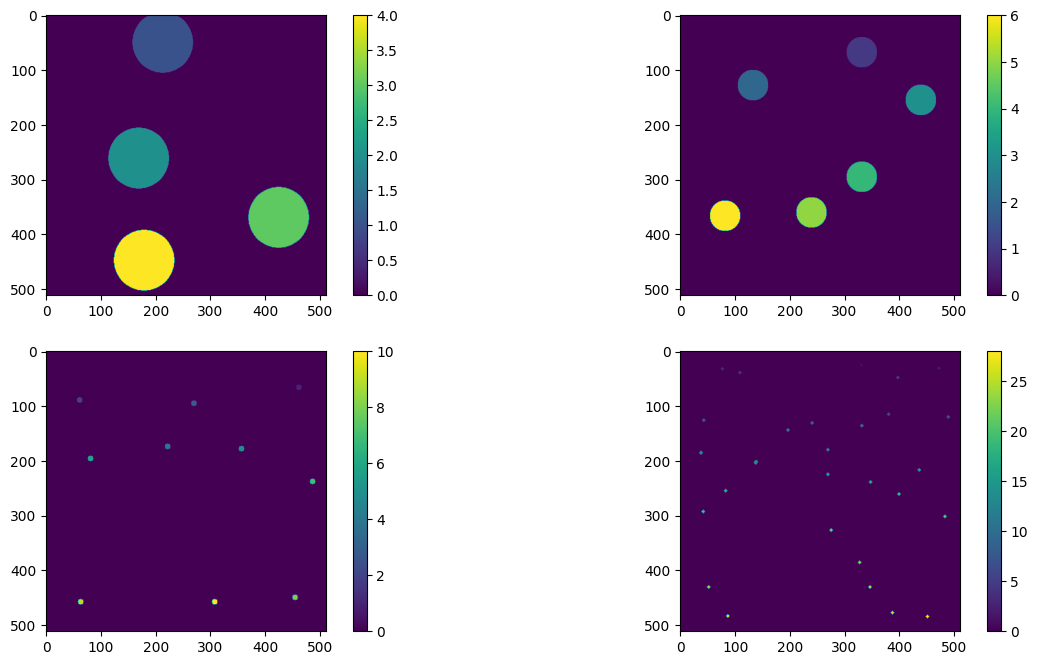

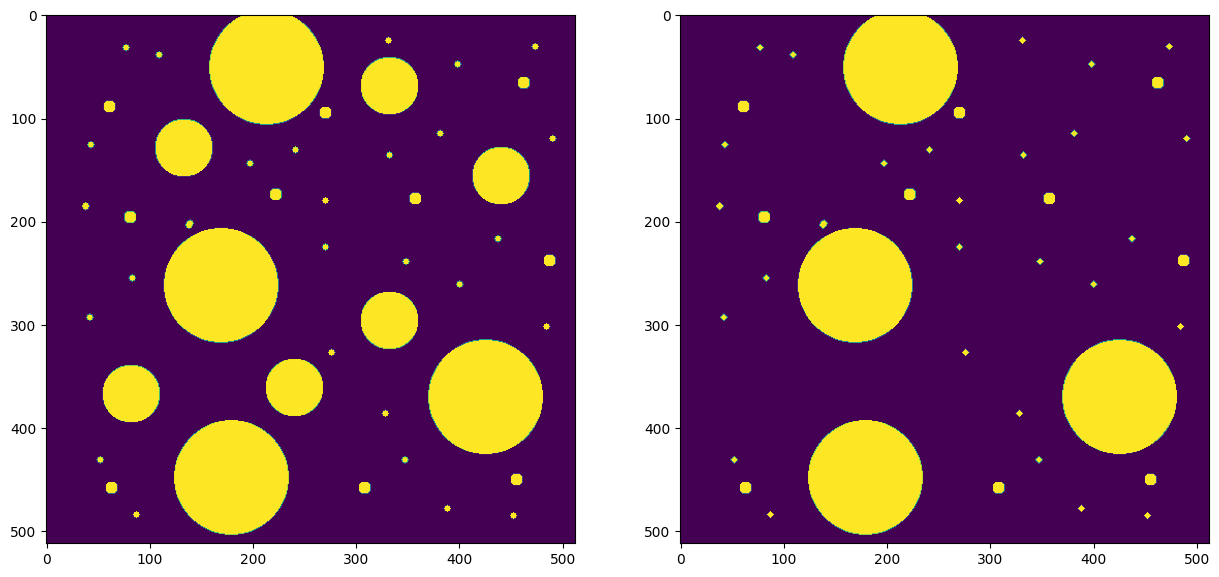

In [11]:
from skimage.morphology import disk, erosion, dilation, closing, opening
from skimage.measure import label, regionprops

im = imread('circles1.png')==0 # to be sure objects are = 1

# added a rectangular shape to see difference of behaviour
# im[190:210, 290:310] = 255

# use the local maximum and local minimum for dilation and erosion
mask = disk(10)

eroded_image = erosion(im, mask)
dilated_image = dilation(im, mask)
opened_image = opening(im, mask) # erosion then dilation
closed_image = closing(im, mask) # dilation then erosion

def show():
    plt.figure(figsize=[10,8])
    plt.subplot(2,3,1)
    plt.imshow(im)
    plt.title('Original')
    plt.subplot(2,3,2)
    plt.imshow(eroded_image)
    plt.title('Erosion')
    plt.subplot(2,3,3)
    plt.imshow(dilated_image)
    plt.title('Dilation')

    plt.subplot(2,3,4)
    plt.imshow(im)
    plt.title('Original')
    plt.subplot(2,3,5)
    plt.imshow(opened_image)
    plt.title('Opening')
    plt.subplot(2,3,6)
    plt.imshow(closed_image)
    plt.title('Closing')
    plt.show()

# show()

# note that "erosion" and "dilation" are the same as the "local minimum" and "local maximum" :
# from skimage.filters.rank import minimum,maximum
# closing = maximum(minimum(im.astype('uint8'), disk(5)), disk(5))
# opening = minimum(maximum(im.astype('uint8'), disk(5)), disk(5))
# dilation = minimum(im.astype('uint8'), disk(5))
# erosion = maximum(im.astype('uint8'), disk(5))

# What it means is basically that we can apply those basic morphological operations on
# grey scale images to

# 2. Build a morphological filter that eliminates one size of circles

big_circles = opening(opening(im, disk(30)), disk(1))
medium_circles = opening((opening(im, disk(10))==0 + big_circles)==0, disk(1))
small_circles = opening((opening(im, disk(5))==0 + medium_circles + big_circles)==0, disk(1))
little_circles = opening((im==0 + big_circles + medium_circles + small_circles)==0, disk(1))

def number_of_circle():
    big_lab = label(big_circles,background=0)
    medium_lab = label(medium_circles,background=0)
    small_lab = label(small_circles,background=0)
    little_lab = label(little_circles,background=0)

    print("Number of big circles :", len(regionprops(big_lab)))
    print("Number of medium circles :", len(regionprops(medium_lab)))
    print("Number of small circles :", len(regionprops(small_lab)))
    print("Number of little circles :", len(regionprops(little_lab)))

    plt.figure(figsize=[15,8])
    plt.subplot(2,2,1)
    plt.imshow(big_lab)
    plt.colorbar()
    plt.subplot(2,2,2)
    plt.imshow(medium_lab)
    plt.colorbar()
    plt.subplot(2,2,3)
    plt.imshow(small_lab)
    plt.colorbar()
    plt.subplot(2,2,4)
    plt.imshow(little_lab)
    plt.colorbar()
    plt.show()

number_of_circle()

def make_disappear(im, size):
    mask = im
    if size == "little":
        mask = little_circles
    elif size == "small":
        mask = small_circles
    elif size == "medium":
        mask = medium_circles
    elif size == "big":
        mask = big_circles

    return (im==0 + mask)==0

plt.figure(figsize=[15,8])
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(opening(make_disappear(im, 'medium'), disk(1)))
plt.show()

def show_morphological_filters():
    plt.figure(figsize=[10,8])
    plt.subplot(2,2,1)
    plt.imshow(little_circles)
    plt.subplot(2,2,2)
    plt.imshow(small_circles)
    plt.subplot(2,2,3)
    plt.imshow(medium_circles)
    plt.subplot(2,2,4)
    plt.imshow(big_circles)
    plt.show()

# show_morphological_filters()

def show2():
    plt.figure(figsize=[10,8])
    plt.subplot(2,2,1)
    plt.imshow(im)
    plt.title('Original')
    plt.subplot(2,2,2)
    plt.imshow(opening(im, disk(5)))
    plt.subplot(2,2,3)
    plt.imshow(opening(im, disk(10)))
    plt.subplot(2,2,4)
    plt.imshow((im==0 + opening(im, disk(30)))==0)
    plt.show()

# show2()

**Need more help? You can check the following videos:**

* [Morphological operations](https://www.youtube.com/watch?v=b64M2dZaWPA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=20)

## 5. Edge detection

Using the [convolve2d](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.convolve2d.html) function, develop the Sobel filter. 
The Sobel operator is given by
$$\mathbf{G} = \sqrt{ {\mathbf{G}_x}^2 + {\mathbf{G}_y}^2 }$$
where $G_x$ and $G_y$ are images respectively obtained by a convolution with the given kernels
$$\mathbf{g}_y = \begin{bmatrix} 
    -1 & -2 & -1  \\
    0 & 0 & 0 \\
    +1 & +2 & +1 
    \end{bmatrix}
    \quad
    \mbox{and}
    \quad   
    \mathbf{g}_x = \begin{bmatrix} 
    -1 & 0 & +1 \\
    -2 & 0 & +2 \\
    -1 & 0 & +1 
    \end{bmatrix}
    $$

**Apply the Sobel filter** to find the edges in the "road" image.

Compare with the results of the **Canny edge filter** with different "sigma" values (see [the skimage documentation](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html))

/var/folders/4s/d117mc114zx7dd3fd3wr9xb00000gn/T/ipykernel_3560/1693460927.py:25: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  median_im = median(im, disk(2))
/var/folders/4s/d117mc114zx7dd3fd3wr9xb00000gn/T/ipykernel_3560/1693460927.py:47: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  plt.imshow(canny(median(im, disk(6))))


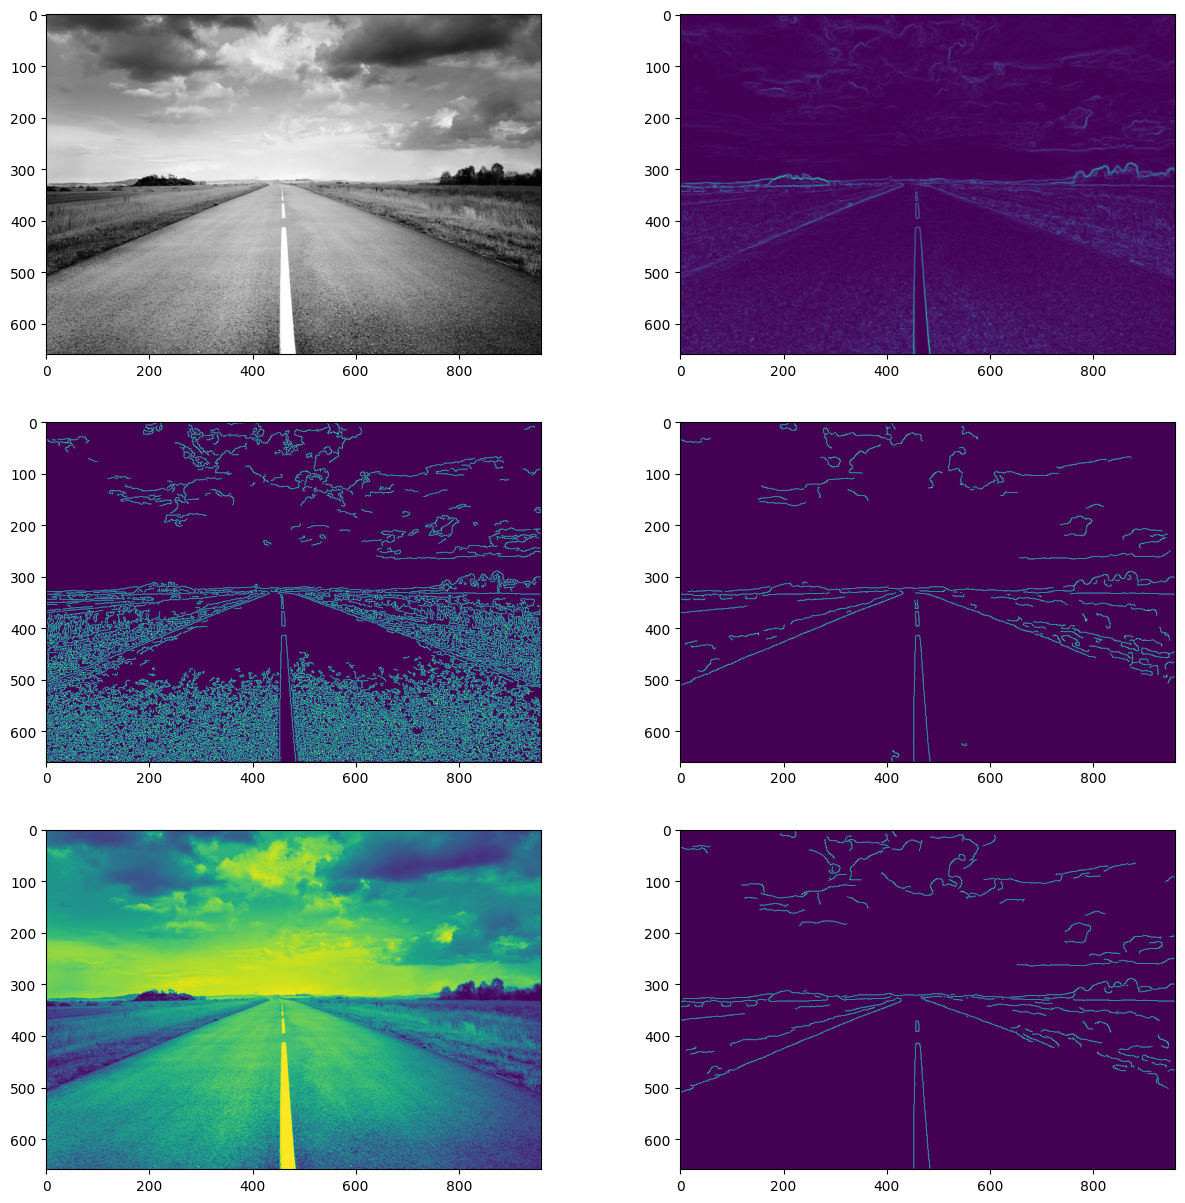

In [12]:
from skimage.data import camera
from skimage.io import imread
from skimage.filters import sobel
from skimage.feature import canny
from skimage.filters.rank import mean, median

im = imread('road.jpg', as_gray=True)

# 1. Sobel filter
gy = np.array([
    [-1,-2,-1],
    [ 0, 0, 0],
    [ 1, 2, 1]
])
gx = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

im_gx = convolve2d(im, gx)
im_gy = convolve2d(im, gy)

# sobel_filtered = np.sqrt(im_gy**2 + im_gx**2)
median_im = median(im, disk(2))
sobel_filtered = sobel(median_im)

# 2. Canny edge filter
canny_edge = canny(im)

# Apply a blur before searching for borders
canny_edge_gaussian = canny(im, sigma=2.5)

def show():
    plt.figure(figsize=(15,15))
    plt.subplot(3, 2, 1)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.subplot(3, 2, 2)
    plt.imshow(sobel_filtered)
    plt.subplot(3, 2, 3)
    plt.imshow(canny_edge)
    plt.subplot(3, 2, 4)
    plt.imshow(canny_edge_gaussian)
    plt.subplot(3, 2, 5)
    plt.imshow(im)
    plt.subplot(3, 2, 6)
    plt.imshow(canny(median(im, disk(6))))
    plt.show()

show()

Use the **[Hough transform](http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html)** to find the main straight lines in the road image, using the results from the Canny edge detector.

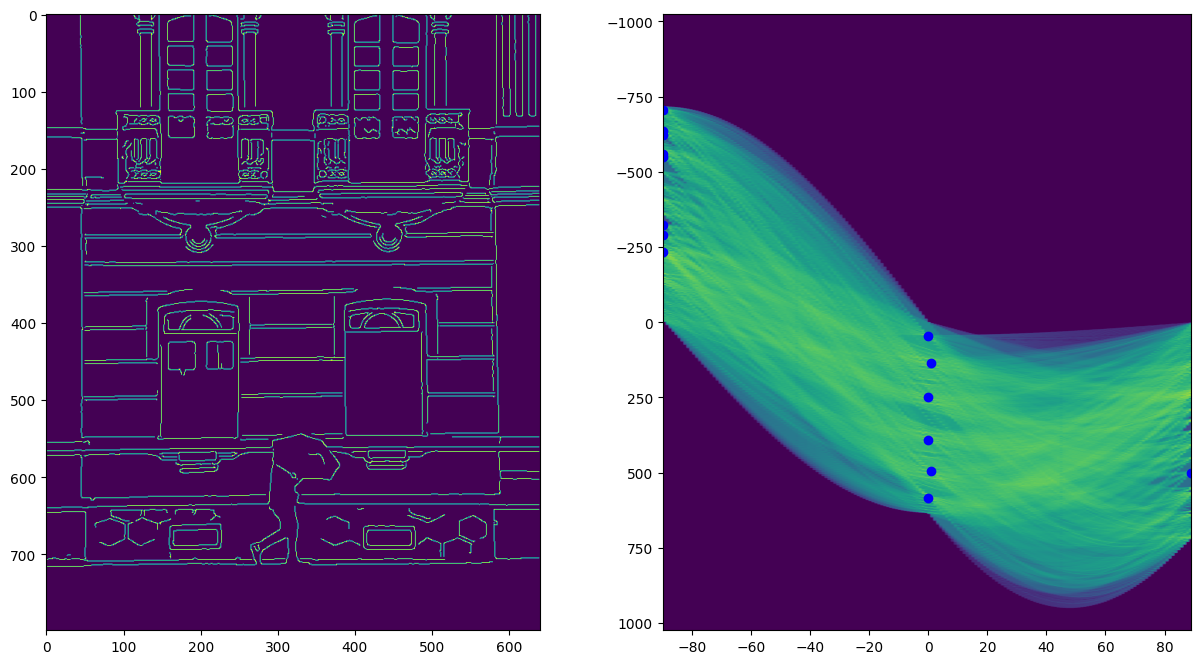

/var/folders/4s/d117mc114zx7dd3fd3wr9xb00000gn/T/ipykernel_3560/395958999.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  y0 = (dists[i] - x0*np.cos(angles[i]))/np.sin(angles[i])
/var/folders/4s/d117mc114zx7dd3fd3wr9xb00000gn/T/ipykernel_3560/395958999.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  y1 = (dists[i] - x1*np.cos(angles[i]))/np.sin(angles[i])


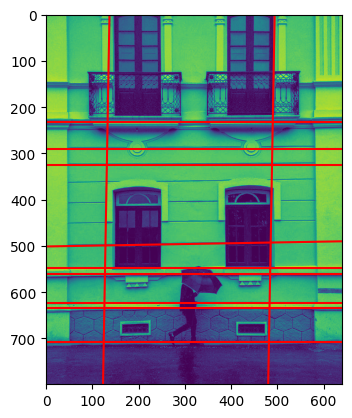

In [13]:
from skimage.transform import hough_line, hough_line_peaks

im = imread("walking.jpg")
borders = canny(im, sigma=2)
h, theta, d = hough_line(borders)

hpeaks, angles, dists = hough_line_peaks(h, theta, d)

def show_hough():
    plt.figure(figsize=[15, 8])
    plt.subplot(1,2,1)
    plt.imshow(borders)
    plt.subplot(1,2,2)
    plt.imshow(np.log(h+1), extent=(np.rad2deg(theta[0]), np.rad2deg(theta[-1]), d[-1], d[0]), aspect='auto')
    plt.plot(np.rad2deg(angles), dists, 'bo')
    plt.show()

    plt.figure()
    plt.imshow(im)
    for i in range(len(hpeaks)):
        x0 = 0
        x1 = im.shape[1]
        y0 = (dists[i] - x0*np.cos(angles[i]))/np.sin(angles[i])
        y1 = (dists[i] - x1*np.cos(angles[i]))/np.sin(angles[i])
        plt.plot((x0, x1), (y0, y1), '-r')
    plt.xlim((0, im.shape[1]))
    plt.ylim((im.shape[0], 0))
    plt.show()

show_hough()

**Need more help? You can check the following videos:**

* [Edge detection with the Sobel filter](https://www.youtube.com/watch?v=QCjh8yyW-Wo&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=21)
* [Edge detection with the Canny transform](https://www.youtube.com/watch?v=yS5NnpWmuuI&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=22)
* [Line detection with the Hough Transform](https://www.youtube.com/watch?v=GD2xipfKQyY&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=23)

# Coding project - Picture enhancement

Write code that automatically enhances a photograph.

<img src="etretat.jpg" width="250px" />
<img src="ex_enhance.jpg" width="250px" />

"Enhance" may mean a lot of different things, and we encourage you to be creative in which enhancements you want to implement.

Some possibilities include (not an exhaustive list):

* Noise reduction
* Auto-level
* Gamma correction (with gamma provided by the user or automatically determined from the image histogram)
* Increase colour saturation
* ...

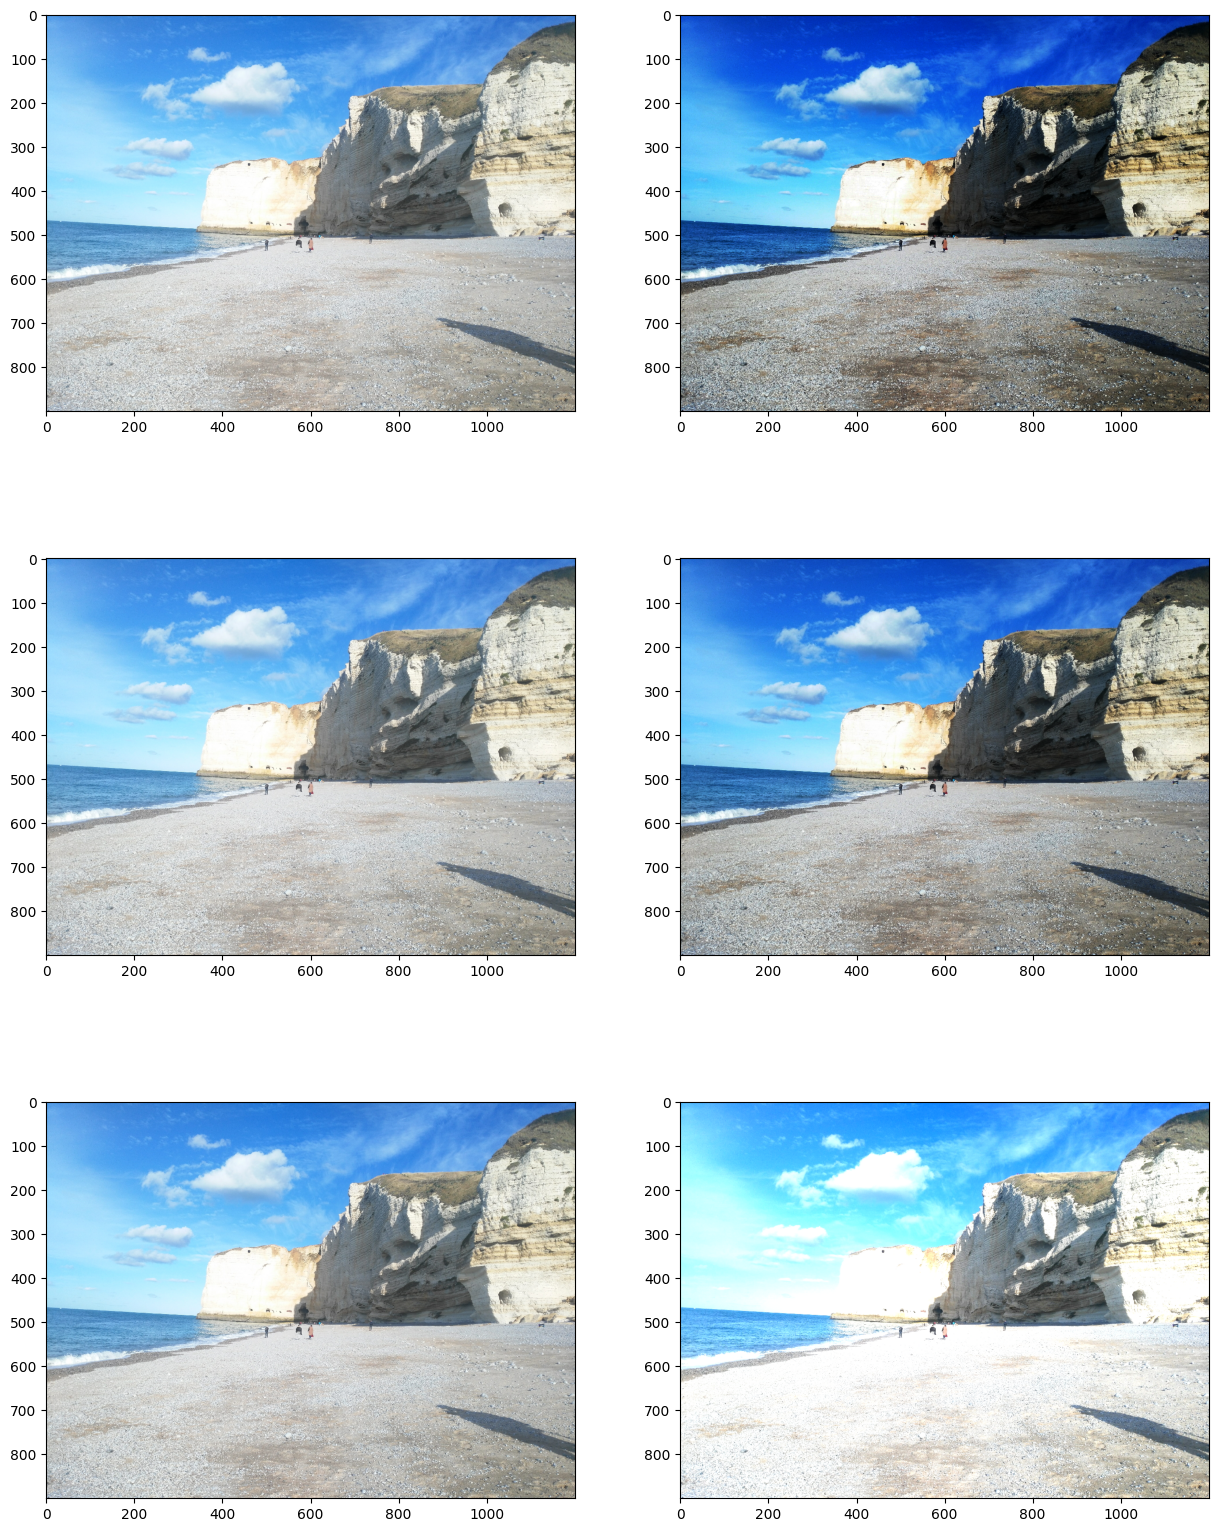

In [17]:
from skimage.color import rgb2hsv, hsv2rgb
from skimage.io import imread,imshow,imsave

im = imread('etretat.jpg')

# Equalize the image
histogram = cumulative(im)
lut_equalize = (histogram*255).astype('uint8')
im_equalized = lut_equalize[im]

# Gamma transformation
gamma = 1.7
lut_gamma = (np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)).astype('uint8')
gamma_corrected = lut_gamma[im]

# Auto-level
th_min, th_max = 20,200
low_val, high_val = 0, 255

lut_stretch = np.arange(256)
lut_stretch[:th_min], lut_stretch[th_max:] = low_val, high_val
lut_stretch[th_min:th_max] = (high_val-low_val)/(th_max-th_min) * (lut_stretch[th_min:th_max] - th_min) + low_val

auto_leveled = lut_stretch[im]

def show_enhanced():
    nb_line = 3
    nb_column = 2
    plt.figure(figsize=[15,20])

    plt.subplot(nb_line, nb_column, 1)
    plt.imshow(im)
    plt.subplot(nb_line, nb_column, 2)
    plt.imshow(im_equalized)

    plt.subplot(nb_line, nb_column, 3)
    plt.imshow(im)
    plt.subplot(nb_line, nb_column, 4)
    plt.imshow(gamma_corrected)

    plt.subplot(nb_line, nb_column, 5)
    plt.imshow(im)
    plt.subplot(nb_line, nb_column, 6)
    plt.imshow(auto_leveled)
    plt.show()

show_enhanced()